# Gaussian Process Regression
**COMP9418-17s2, W09 Tutorial**

*School of Computer Science and Engineering, UNSW Sydney*

- **Instructor**: Edwin V. Bonilla
- **Teaching Assistant**: Louis Tiao

We will be using Gaussian process (GP) models for regression. A Gaussian process defines a prior distribution over functions, which we use to obtain a posterior distribution over functions after having observed some data. As such, the predictions from a GP model take the form of a full predictive distribution.

In this week's lab, we will focus gaining a practical understanding of these concepts - how to sample from a prior over functions, how to obtain and visualize the full predictive distribution, how the characteristics of a GP model changes as we vary some underlying hyperparameters, and so on. Finally, we will apply a GP regression model to a real-world dataset, and select a covariance function and its parameters to obtain automatic relevance determination (ARD), which can help us discard the irrelevant features. For a more complete treatment of Gaussian processes for regression, please refer to [GPML](http://www.gaussianprocess.org/gpml/) $\S$2.2 (Rasmussen & Williams, 2006) or [MLaPP](https://www.cs.ubc.ca/~murphyk/MLbook/) $\S$15.2 (Murphy, 2012)

This lab makes extensive use of [GPFlow](https://github.com/GPflow/GPflow), with portions derived directly from their tutorial [GP Regression with GPflow](http://gpflow.readthedocs.io/en/latest/notebooks/regression.html).

### Preamble

The following Python packages are required for this exercise:

- `numpy`
- `pandas`
- `scikit-learn`
- `tensorflow`
- `GPflow`
- `matplotlib`

Most of these may be installed with `pip`:

    pip install numpy pandas scikit-learn matplotlib tensorflow

#### Tensorflow Installation

The recommended way to install TensorFlow is in a `virtualenv` with `pip`. If your computer satisfies the [requirements](https://www.tensorflow.org/install/install_linux#nvidia_requirements_to_run_tensorflow_with_gpu_support) to run TensorFlow with GPU support, you should definitely take advantage of it. You can install TensorFlow with GPU support

    pip install tensorflow-gpu

You can also take advantage of specialized CPU instruction sets for numerical computing by compiling TensorFlow from sources. This is outside the scope of this lab and we refer you to the [install guide](https://www.tensorflow.org/install/install_sources) for this.

See the [full install guide](https://www.tensorflow.org/install/) for comprehensive instructions on installing TensorFlow for different environments with different options.

#### GPflow Installation

GPflow has not been released on PyPI. You can either download the package from the [official Github repo](https://github.com/GPflow/GPflow) and run `python setup.py install`, or install directly from Github via `pip` (recommended):

    pip install git+https://github.com/GPflow/GPflow.git

See the [install guide](http://gpflow.readthedocs.io/en/latest/intro.html#install) for further information.

Here we import the required modules and set up our notebook environment

In [6]:
%matplotlib notebook

In [7]:
from __future__ import division
from __future__ import print_function

# Required modules
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from IPython.display import Markdown

In [8]:
plt.style.use('seaborn-notebook')
np.set_printoptions(precision=3, 
                    edgeitems=5,  
                    suppress=False)

#### Constant Definitions

In [9]:
n_train = 12 # nbr. training points in synthetic dataset
n_query = 100 # nbr. query points
seed = 23 # set random seed for reproducibility
rng = np.random.RandomState(seed)

### Synthetic Dataset

First let's create a small synthetic dataset with `n_train` datapoints.

In [10]:
X = rng.rand(n_train, 1)
Y = np.sin(12.*X) + .66*np.cos(25.*X) + rng.randn(n_train, 1)*.1 + 3.

<IPython.core.display.Javascript object>


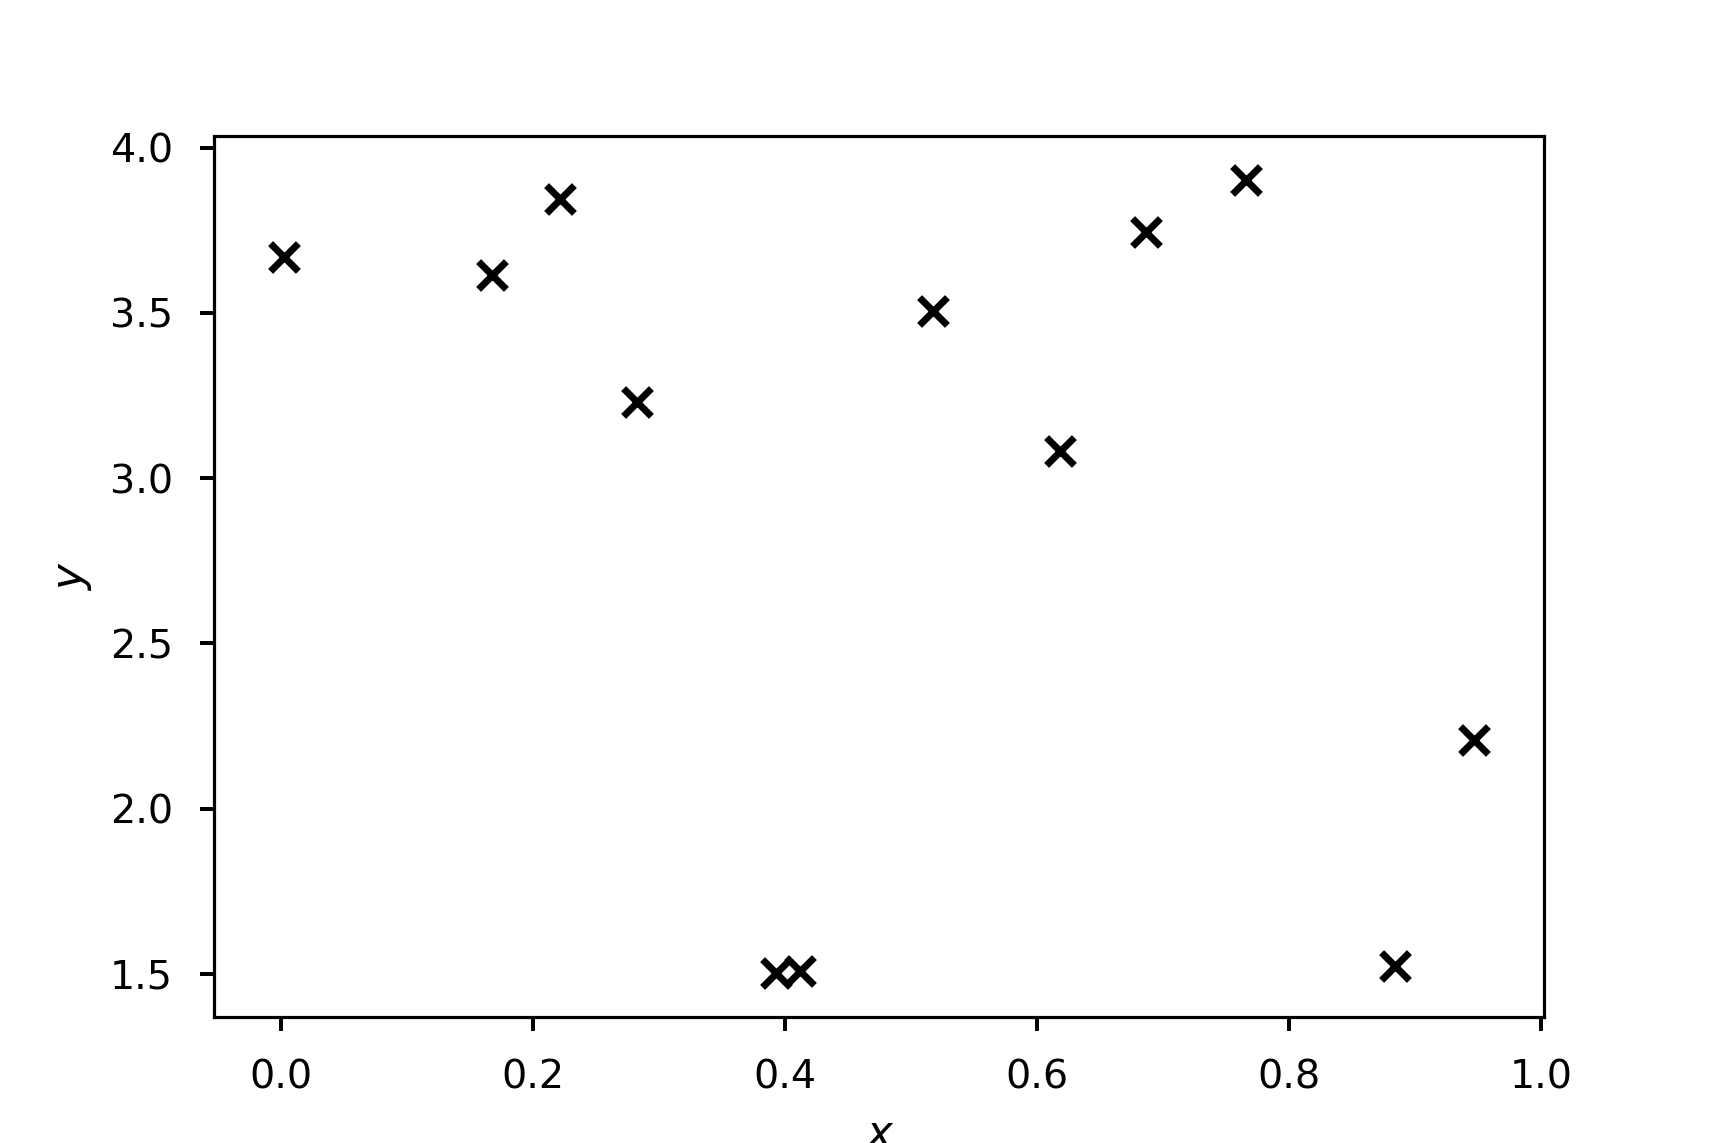

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(X, Y, marker='x', color='k')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## Model specification

A Gaussian process model is specified in terms of a mean function $m(\mathbf{x})$ and kernel or covariance function $\kappa(\mathbf{x}, \mathbf{x}')$. The Gaussian process prior on regression functions is denoted by

$$
f(\mathbf{x}) \sim GP(m(\mathbf{x}), \kappa(\mathbf{x}, \mathbf{x}'))
$$

It is common to simply specify $m(x)=0$ since the GP is flexible enough to also model the mean arbitrarily well, so let's go ahead and specify a covariance function.

### Kernels (covariance functions)

GPFlow offers a number of commonly-used kernels, as well as an interface to define your own. See the tutorial [Using kernels in GPflow](http://gpflow.readthedocs.io/en/latest/notebooks/kernels.html) for more information. Let's take a look at the Radial Basis Function (RBF, also known as squared-exponential) kernel.

In [12]:
# RBF kernel with input_dim=2 and lengthscale=1.
k = gpflow.kernels.RBF(1, lengthscales=1.)

For any finite set of $N$ points $\mathbf{X}$, the GP prior above defines a joint Gaussian

$$
p(\mathbf{f} \mid \mathbf{X}) = \mathcal{N}(\mathbf{f} \mid \boldsymbol{\mu}, \mathbf{K})
$$

where $K_{ij} = \kappa(\mathbf{x}_i, \mathbf{x}_j)$ and $\boldsymbol{\mu} = (m(\mathbf{x}_1, \dotsc, \mathbf{x}_N))$.

Let's define a set of `n_query` points.

In [13]:
Xq = np.linspace(-5., 5., n_query).reshape(-1, 1)

With one input fixed at 0, we can see how the kernel changes as the other input varies and moves away from 0. The method `compute_K` takes 2 arrays as arguments and gives the kernel computed pairwise between the points in the arrays.

<IPython.core.display.Javascript object>


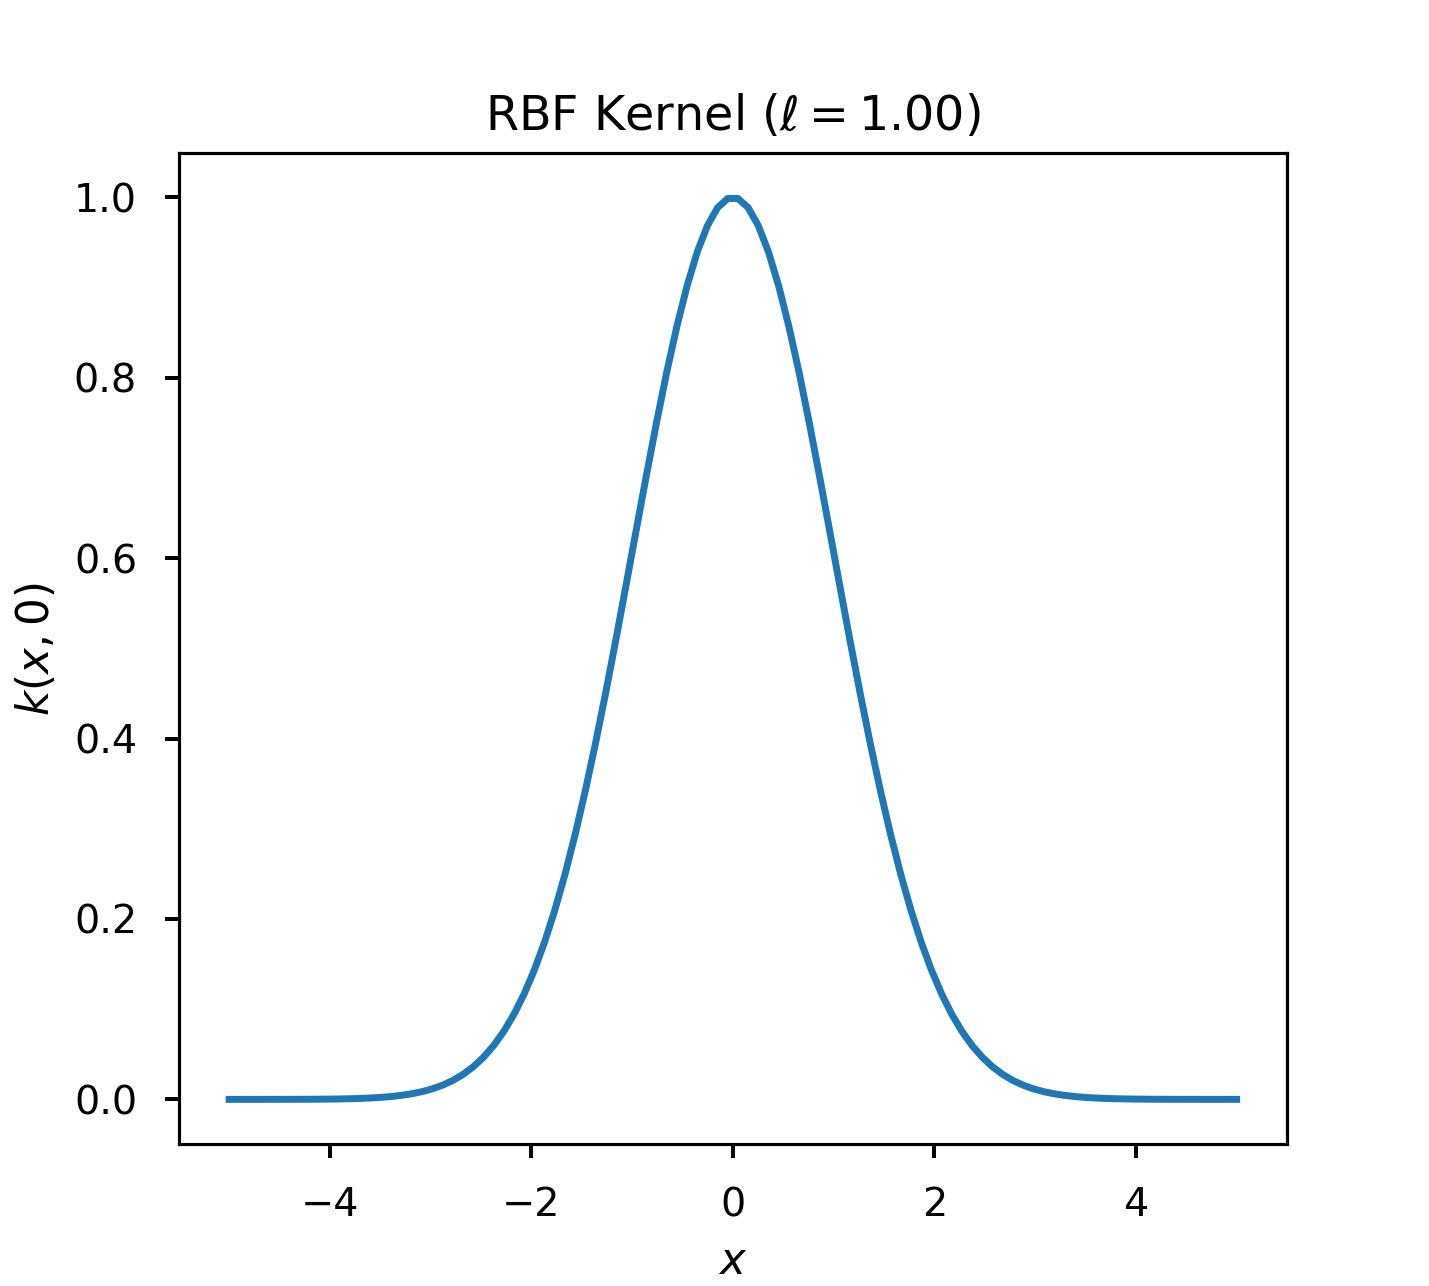

In [14]:
fig, ax = plt.subplots(figsize=(5, 4.5))

ax.plot(Xq, k.compute_K(Xq, np.zeros(1).reshape(-1, 1)))

ax.set_xlabel('$x$')
ax.set_ylabel('$k(x, 0)$')
ax.set_title('RBF Kernel ($\ell={{{[0]:.2f}}}$)'
             .format(k.lengthscales.value))

plt.show()

Now let's call `compute_K_symm` on $\mathbf{X}$, which gives the covariance matrix $\mathbf{K}$ described above. We can then sample functions $\mathbf{f}$ from the joint Gaussian with covariance $\mathbf{K}$. This is what it means to sample functions from a GP prior. Note that $\mathbf{f}$ is a collection of function values evaluated at the finite set of points in $\mathbf{X}$.  

### Exercise

Implement the function `prior_samples`, which takes a 2d array of points, a GPFlow kernel and integer argument `n_samples`, and returns `n_samples` samples of function $\mathbf{f}$ from the GP prior with zero mean function $m(\mathbf{x})=0$ and the specified kernel.

Note that while the set of `n_query` finite points `Xq` we're working with is 1-dimensional, we defined it to be a 2d array of shape `(n_query, 1)`. This is because GPFlow only accepts 2d arrays.

In [ ]:
### EXERCISE ###
def prior_samples(x, kernel, n_samples=3):

    # mean vector
    mu = np.squeeze(np.zeros_like(x))
    # covariance matrix
    K = kernel.compute_K_symm(x)

    # TODO: return n_samples from a joint Gaussian distribution
    return ...

In [15]:
### SOLUTION ###
def prior_samples(x, kernel, n_samples=3):

    mu = np.squeeze(np.zeros_like(x))
    K = kernel.compute_K_symm(x)

    return rng.multivariate_normal(mu, K, n_samples).T

In [27]:
np.squeeze(np.zeros_like([1,2,3,1,0,-1]))

array([0, 0, 0, 0, 0, 0])

Now we can visualize draws from the GP prior.

<IPython.core.display.Javascript object>


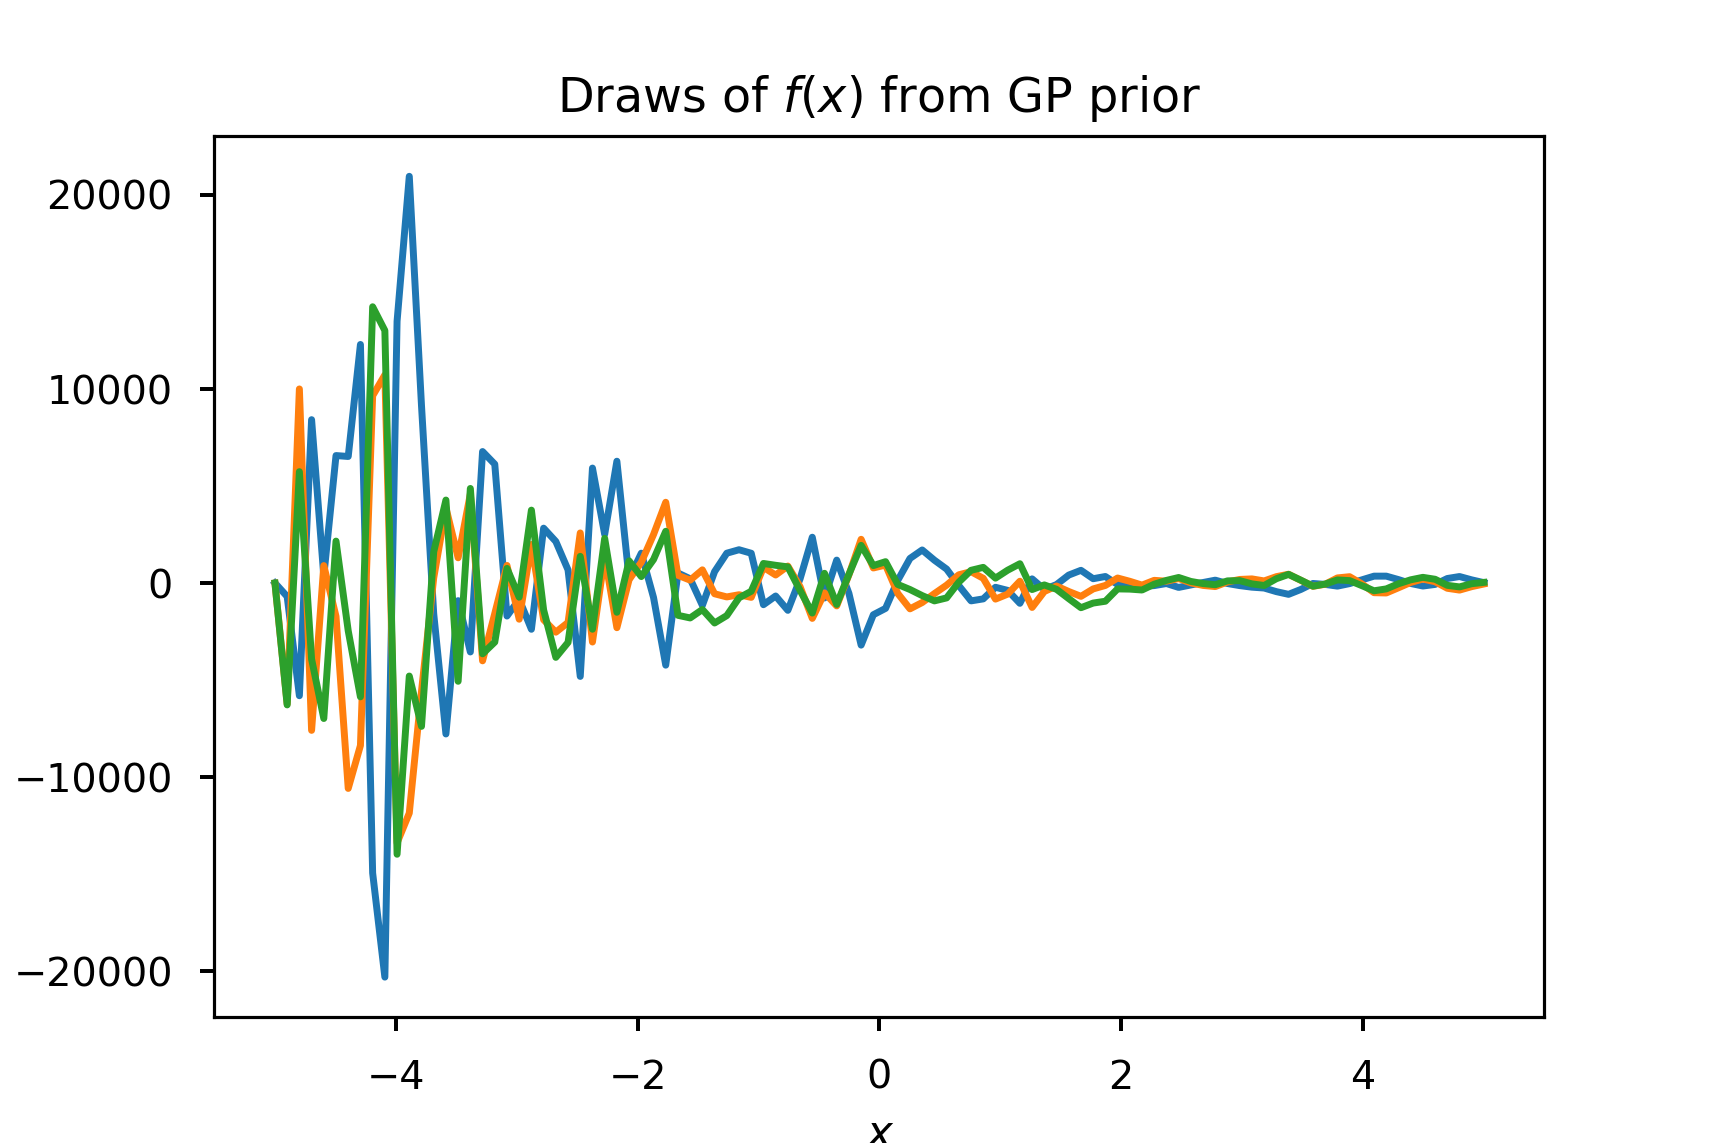

[[  6.523e-01  -5.999e+00  -2.430e+00]
 [ -6.960e+02  -6.235e+03  -6.283e+03]
 [ -5.809e+03   1.000e+04   5.739e+03]
 [  8.420e+03  -7.595e+03  -3.923e+03]
 [  3.582e+02   8.992e+02  -6.983e+03]
 [  6.570e+03  -1.721e+03   2.160e+03]
 [  6.522e+03  -1.059e+04  -2.464e+03]
 [  1.230e+04  -8.375e+03  -5.867e+03]
 [ -1.495e+04   9.652e+03   1.424e+04]
 [ -2.031e+04   1.073e+04   1.301e+04]
 [  1.349e+04  -1.339e+04  -1.398e+04]
 [  2.096e+04  -1.186e+04  -4.795e+03]
 [  9.147e+03  -5.579e+03  -7.388e+03]
 [ -1.578e+03   2.590e+02   1.606e+03]
 [ -7.780e+03   3.880e+03   4.276e+03]
 [ -9.090e+02   1.301e+03  -5.065e+03]
 [ -3.553e+03   4.590e+03   4.875e+03]
 [  6.777e+03  -4.010e+03  -3.649e+03]
 [  6.125e+03  -1.572e+03  -3.044e+03]
 [ -1.702e+03   9.053e+02   7.549e+02]
 [ -8.394e+02  -1.865e+03  -7.307e+02]
 [ -2.385e+03   1.988e+03   3.757e+03]
 [  2.827e+03  -1.892e+03  -1.386e+03]
 [  2.141e+03  -2.535e+03  -3.831e+03]
 [  6.758e+02  -2.035e+03  -3.062e+03]
 [ -4.814e+03   2.581e+03

/home/yu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


In [30]:
fig, ax = plt.subplots(figsize=(6, 4))
a = prior_samples(Xq, k)
print(a)
ax.plot(Xq, a)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Draws of $f(x)$ from GP prior')

plt.show()

#### Effects of kernel parameters

The kernel variance parameter $\sigma_f$ (`k.variance`) controls the vertical scale of the function, while the length scale $\ell$ (`k.lengthscales`) is the horizontal scale over which the function changes. The sampled functions look smoother as we increase the length scale. This makes sense as the effective distance between query points is inversely proportional to the length scale. Increasing the length scale causes the function values to become less correlated.



<IPython.core.display.Javascript object>


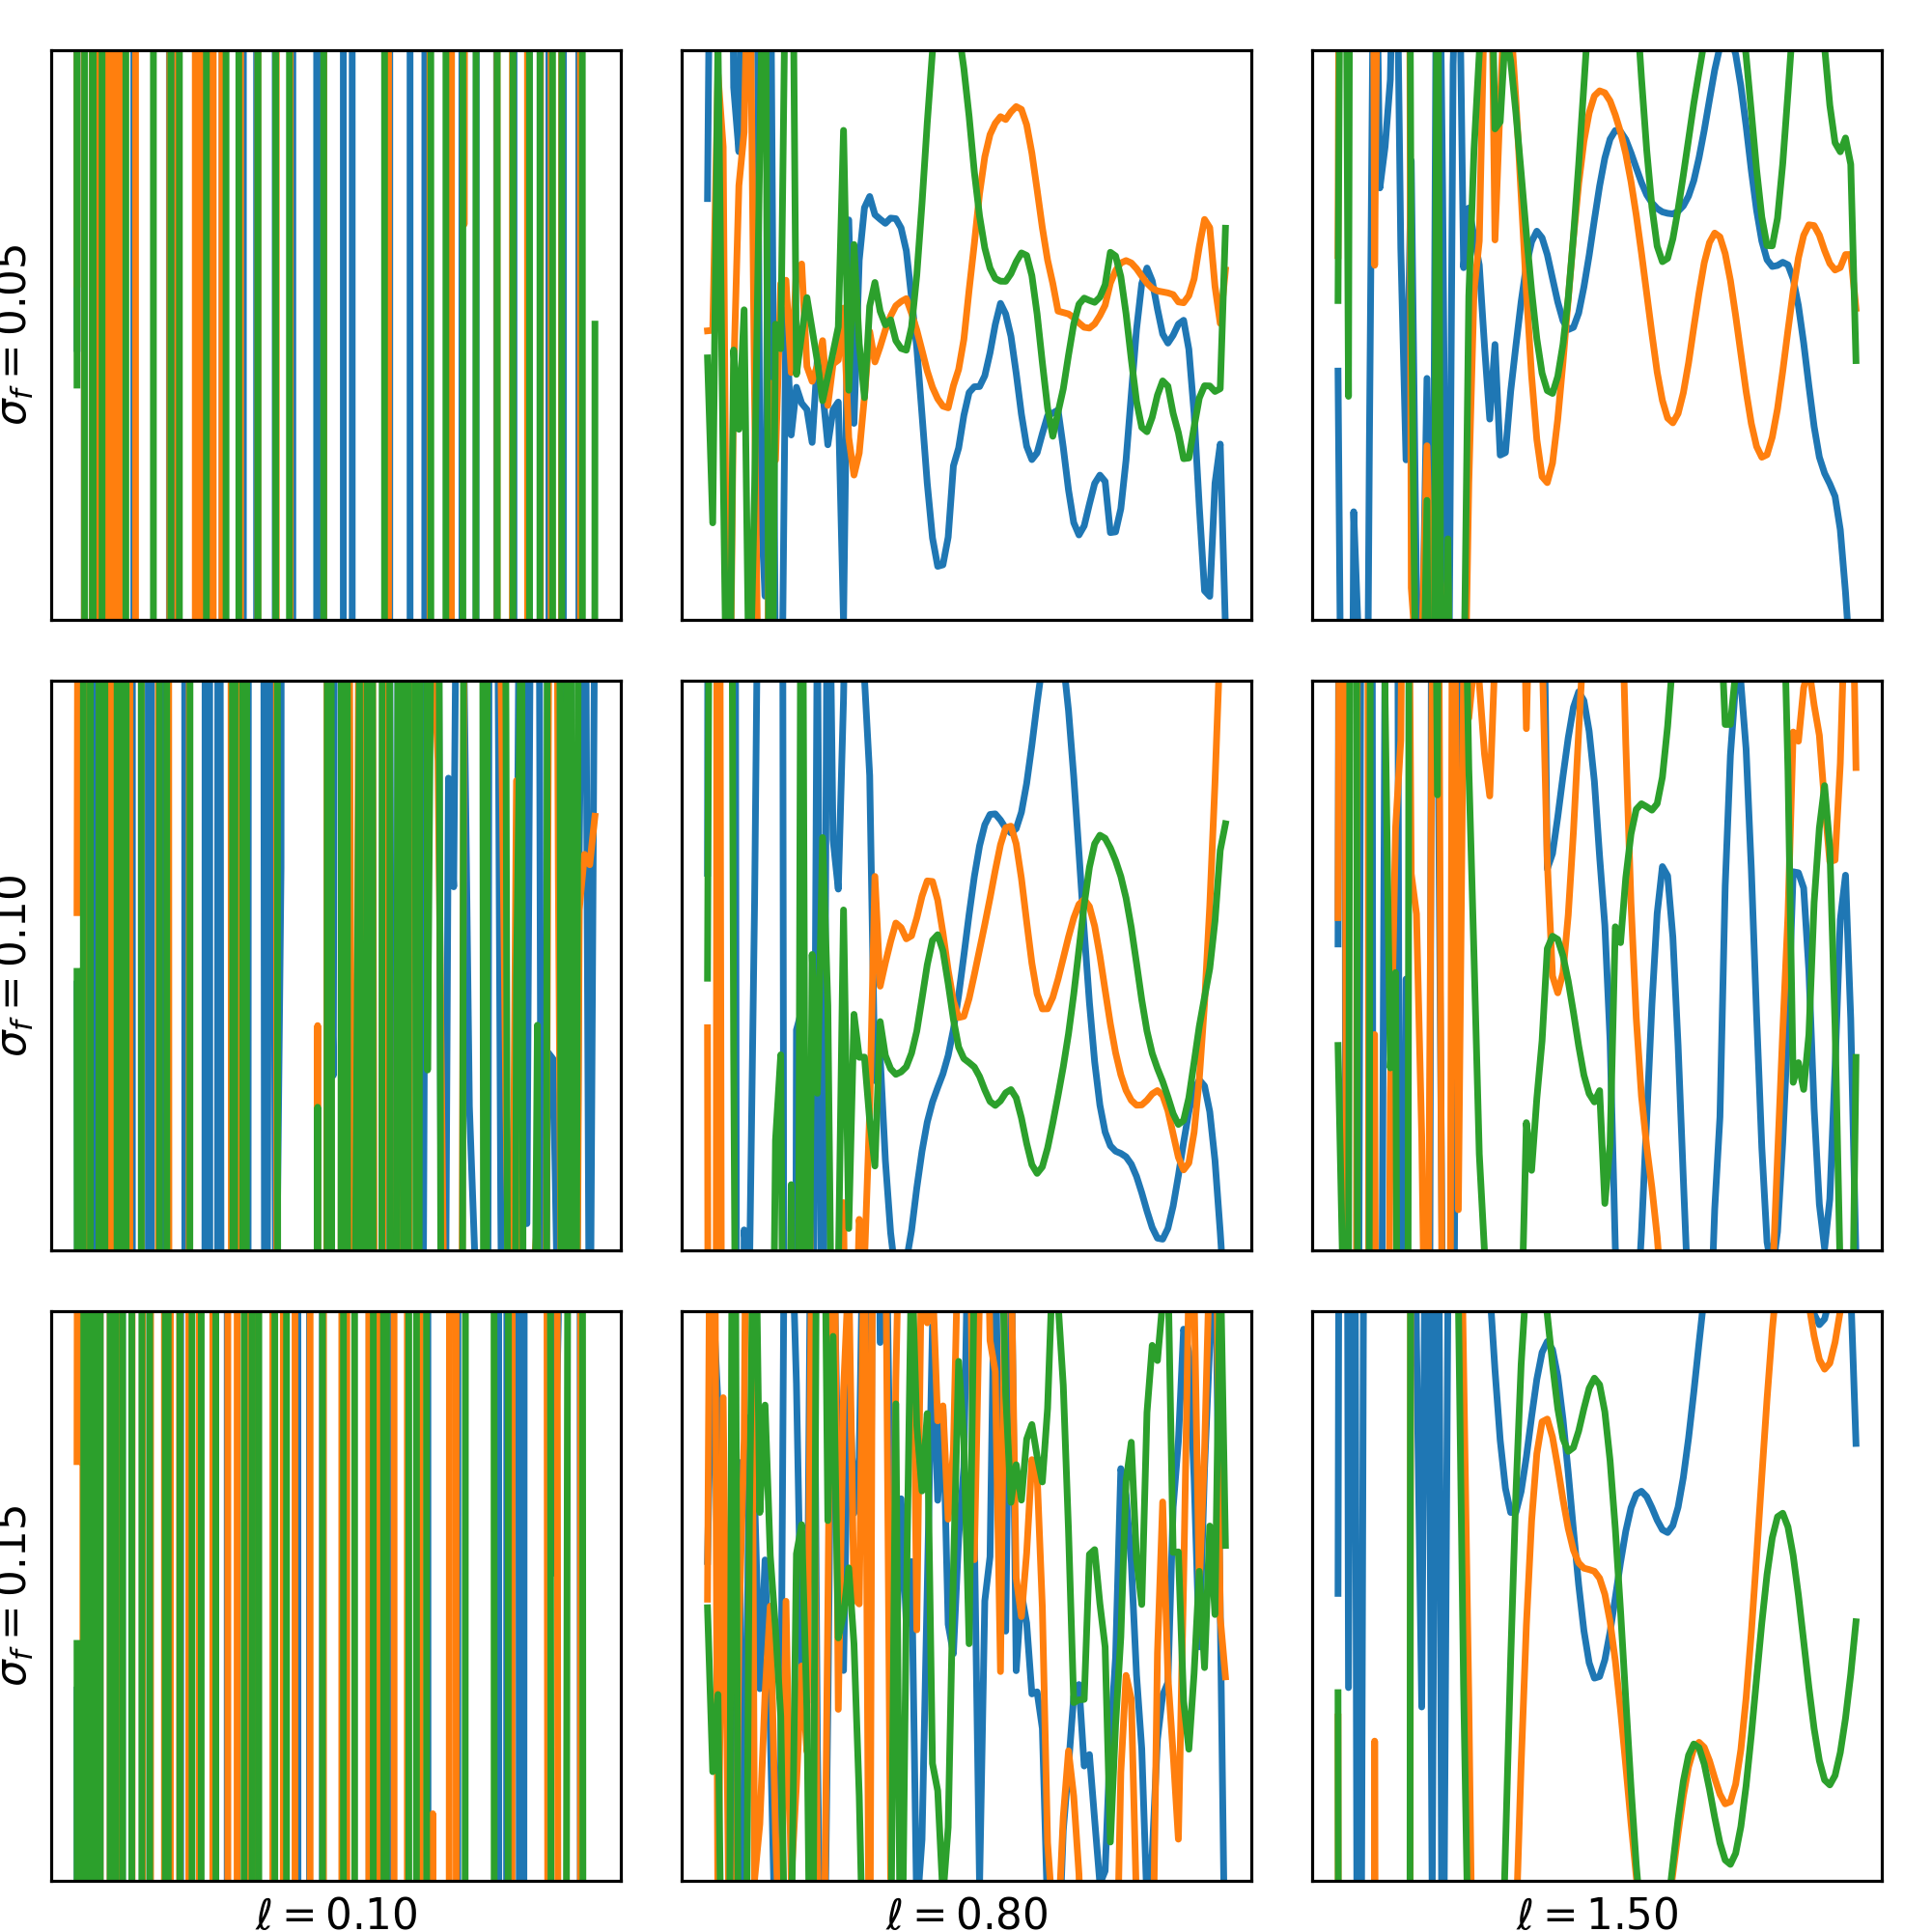

/home/yu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7), 
                         subplot_kw=dict(xticks=[], yticks=[]))
fig.tight_layout()

for i, ax_row in enumerate(axes):

    variance = .05 * (i + 1)
    
    for j, ax in enumerate(ax_row):

        len_scale = .1 + .7 * j

        k = gpflow.kernels.RBF(1, variance=variance,
                               lengthscales=len_scale)
             
        ax.plot(Xq, prior_samples(Xq, k))
        ax.set_ylim(-1.5, 1.5)

        if i == len(axes) - 1:
            ax.set_xlabel('$\ell={{{:.2f}}}$'.format(len_scale))
           
        if not j:
            ax.set_ylabel('$\sigma_f={{{:.2f}}}$'.format(variance))
            
plt.show()

### Posterior predictive distribution

Now suppose we observe the training set $(\mathbf{X}, \mathbf{y})$ we created earlier, where $y_i = f(\mathbf{x}_i) + \epsilon$ is the noisy observation of the function evaluated at $\mathbf{x}_i$ and noise $\epsilon \sim \mathcal{N}(0, \sigma_y^2)$. Given a query set $\mathbf{X}_*$, we can obtain a full posterior distribution over the function outputs $\mathbf{f}_*$. The joint distribution has the following form

$$
\begin{pmatrix}
  \mathbf{y}\\
  \mathbf{f}_*
\end{pmatrix} 
\sim
\mathcal{N} \left (
  0,
  \begin{pmatrix}
    \mathbf{K}_y   & \mathbf{K}_* \\
    \mathbf{K}_*^T & \mathbf{K}_{**}
  \end{pmatrix}
\right )
$$

where

$$
\begin{align}
  \mathbf{K}_y    &= \mathbf{K} + \sigma_y^2\mathbf{I} \\
  \mathbf{K}      &= \kappa(\mathbf{X}, \mathbf{X}) \\
  \mathbf{K}_*    &= \kappa(\mathbf{X}, \mathbf{X}_*) \\
  \mathbf{K}_{**} &= \kappa(\mathbf{X}_*, \mathbf{X}_*)
\end{align}
$$

Then, using the standard method for conditioning Gaussians, the posterior predictive density is given by

$$
\begin{align}
  p(\mathbf{f}_* \mid \mathbf{X}_*, \mathbf{X}, \mathbf{y})
  &= \mathcal{N}(\mathbf{f}_*, \mu_*, \Sigma_*) \\
  \mu_* &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y} \\
  \Sigma_* &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*
\end{align}
$$

Let's instantiate a GP regression model, conditioned on the synthetic training set (`X`, `Y`), with a squared-exponential kernel, and a sensible initial setting of the variance and length scale hyperparameters ($\sigma_y, \sigma_f, \ell$).

In [18]:
k = gpflow.kernels.RBF(1, lengthscales=.2)
m = gpflow.gpr.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

For a given query set $\mathbf{X}_*$, `m.predict_y` returns the means and variances $\mu_*, \Sigma_*$. Additionally, `m.predict_f_samples` yields samples from our posterior. We can use these to visualize the full posterior predictive distribution.

#### Exercise 

Complete the indicated portions of the function `plot_posterior_predictive` below. 

In [19]:
### EXERCISE ###
def plot_posterior_predictive(model, start=0., stop=1., n_query=100, 
                              n_samples=3, ax=None):

    if ax is None:
        ax = plt.gca()

    Xq = np.linspace(start, stop, n_query).reshape(-1, 1)
    # COMPLETE ME #
    # Compute the mean and variances of the predictive 
    # distribution, given the query points `Xq`
    mean, var = ... 

    # scatter plot of the training points
    ax.scatter(model.X.value, model.Y.value, marker='x', color='k')

    # predictive mean mu_*
    ax.plot(Xq, mean, 'b', lw=2., label='$m(x)$')

    # COMPLETE ME #
    # Plot a shaded region that represents mu_* +- 2 std(f_*)
    ax.fill_between(np.squeeze(Xq),
                    # mu_* - 2 std(f_*)
                    # mu_* + 2 std(f_*)
                    color='blue', alpha=.2)
    
    # samples from the posterior distribution
    ax.plot(Xq, np.squeeze(model.predict_f_samples(Xq, n_samples)).T, 
            '--', alpha=.8)

    ax.legend()

In [20]:
### SOLUTION ###
def plot_posterior_predictive(model, start=0., stop=1., n_query=100, 
                              n_samples=3, ax=None):

    if ax is None:
        ax = plt.gca()

    Xq = np.linspace(start, stop, n_query).reshape(-1, 1)
    mean, var = model.predict_y(Xq)

    # scatter plot of the training points
    ax.scatter(model.X.value, model.Y.value, marker='x', color='k')

    # predictive mean mu_*
    ax.plot(Xq, mean, 'b', lw=2., label='$m(x)$')

    ax.fill_between(np.squeeze(Xq),
                    np.squeeze(mean - 2*np.sqrt(var)),
                    np.squeeze(mean + 2*np.sqrt(var)),
                    color='blue', alpha=.2)

    # samples from the posterior distribution
    ax.plot(Xq, np.squeeze(model.predict_f_samples(Xq, n_samples)).T, 
            '--', alpha=.8)

    ax.legend()

This is what the posterior predictive distribution looks like under our GP model. It may seem that our model doesn't yield a great fit. The function is smooth and doesn't interpolate the observed values very well. Furthermore, there is a high degree of uncertainty at the observed points. If we believe our prior and our likelihood models then this is the right answer. However, as we shall see below, we can also estimate the model hyperparameters from the data.

<IPython.core.display.Javascript object>


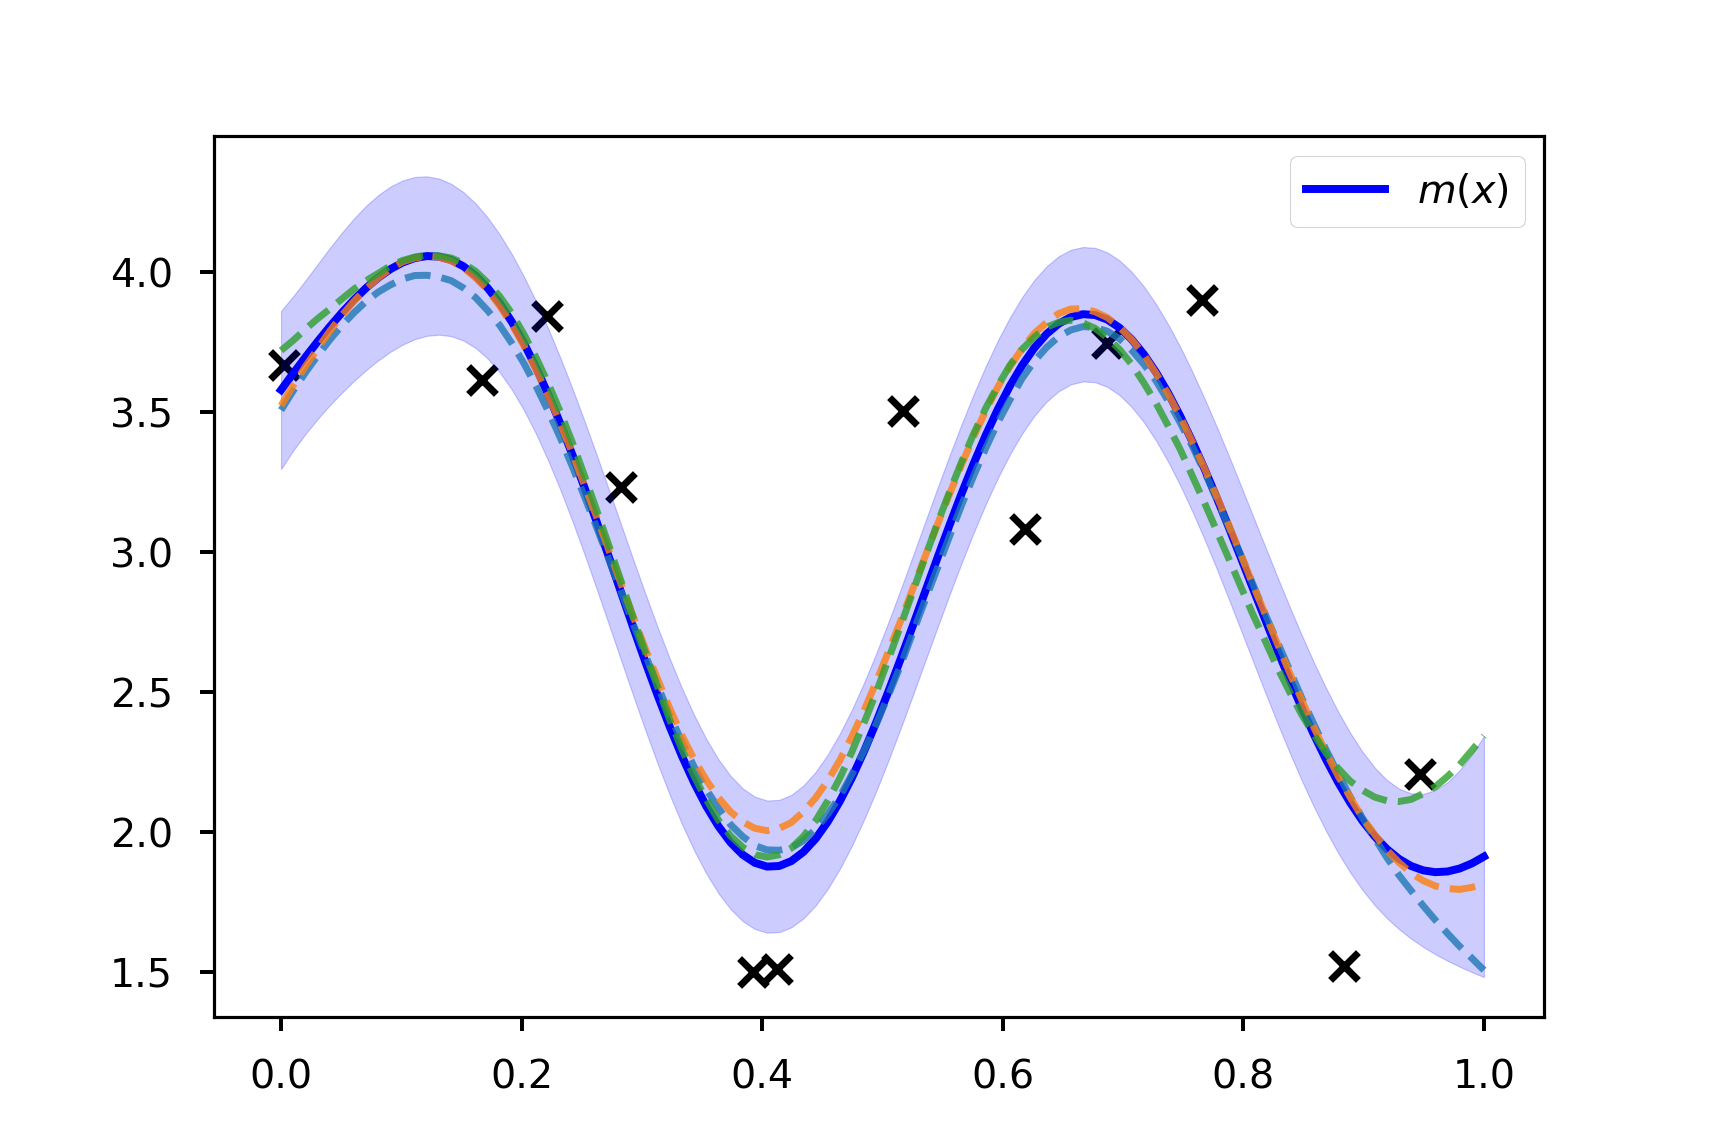

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_posterior_predictive(m, ax=ax)

plt.show()

Similar to what we did with the prior distribution, we can visualize the effects of varying the length scale parameter $\ell$.

<IPython.core.display.Javascript object>


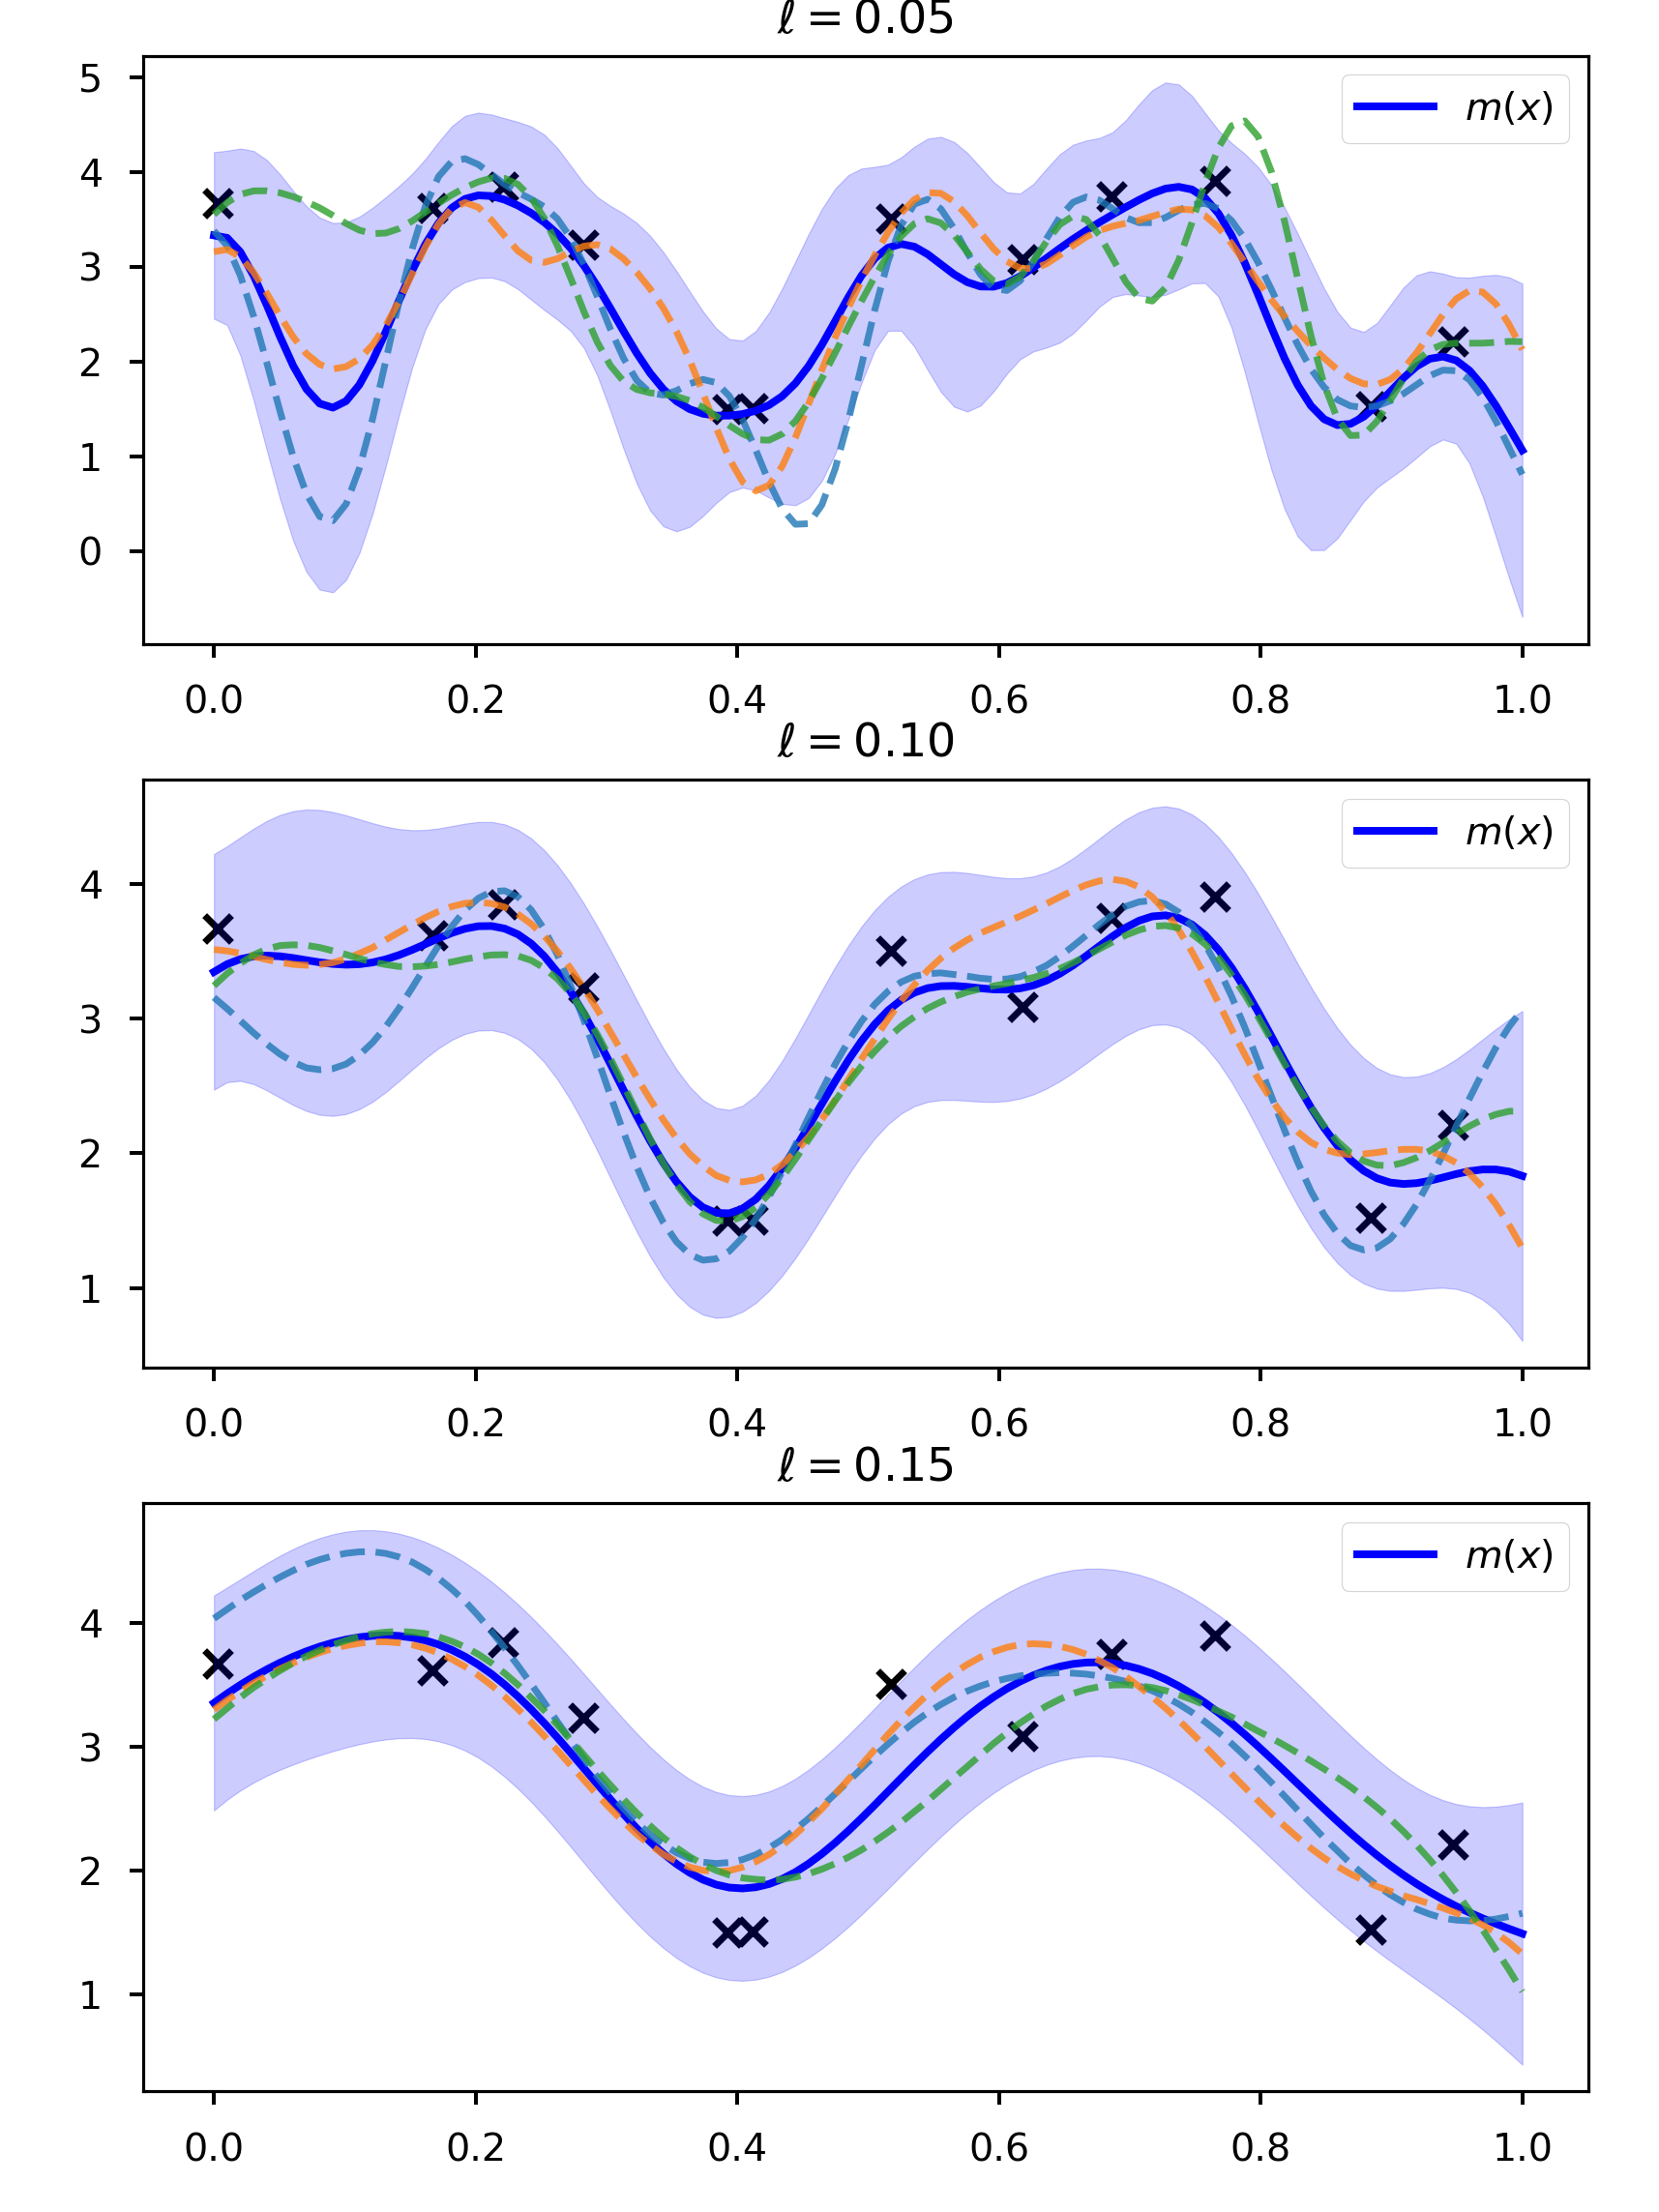

In [22]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 8))
#                          subplot_kw=dict(xticks=[], yticks=[]))
fig.tight_layout()
    
for i, ax in enumerate(axes):

    len_scale = .05 * (i + 1)

    k = gpflow.kernels.RBF(1, lengthscales=len_scale)
    m = gpflow.gpr.GPR(X, Y, kern=k)
    m.likelihood.variance = .1

    ax.set_title('$\ell={{{:.2f}}}$'.format(len_scale))
    plot_posterior_predictive(m, ax=ax)

plt.show()

### Hyperparameter Estimation

To find the kernel parameters that result in the best fit, it is prohibitively slow to exhaustively search over a discrete grid of values to minimize some validation loss. Instead, we resort to an empirical Bayes approach (also known as type II maximum likelihood) where we maximize the *marginal likelihood*. This is much faster and amenable to gradient-based optimization methods.

GPflow implements this in the method `m.optimize` and uses L-BFGS-B from SciPy as the underlying gradient-based optimization procedure. First, we initialize our GP model again an display its parameters:

In [23]:
k = gpflow.kernels.RBF(1, lengthscales=.3)
m = gpflow.gpr.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01
m

Now let us optimize these parameters and display the full predictive distribution again.

In [24]:
m.optimize()
m

We see that this model fits the data much better than our initial model. It interpolates the observed values well and has the highest degree of uncertainty at points furthest away from the observed datapoints.

<IPython.core.display.Javascript object>


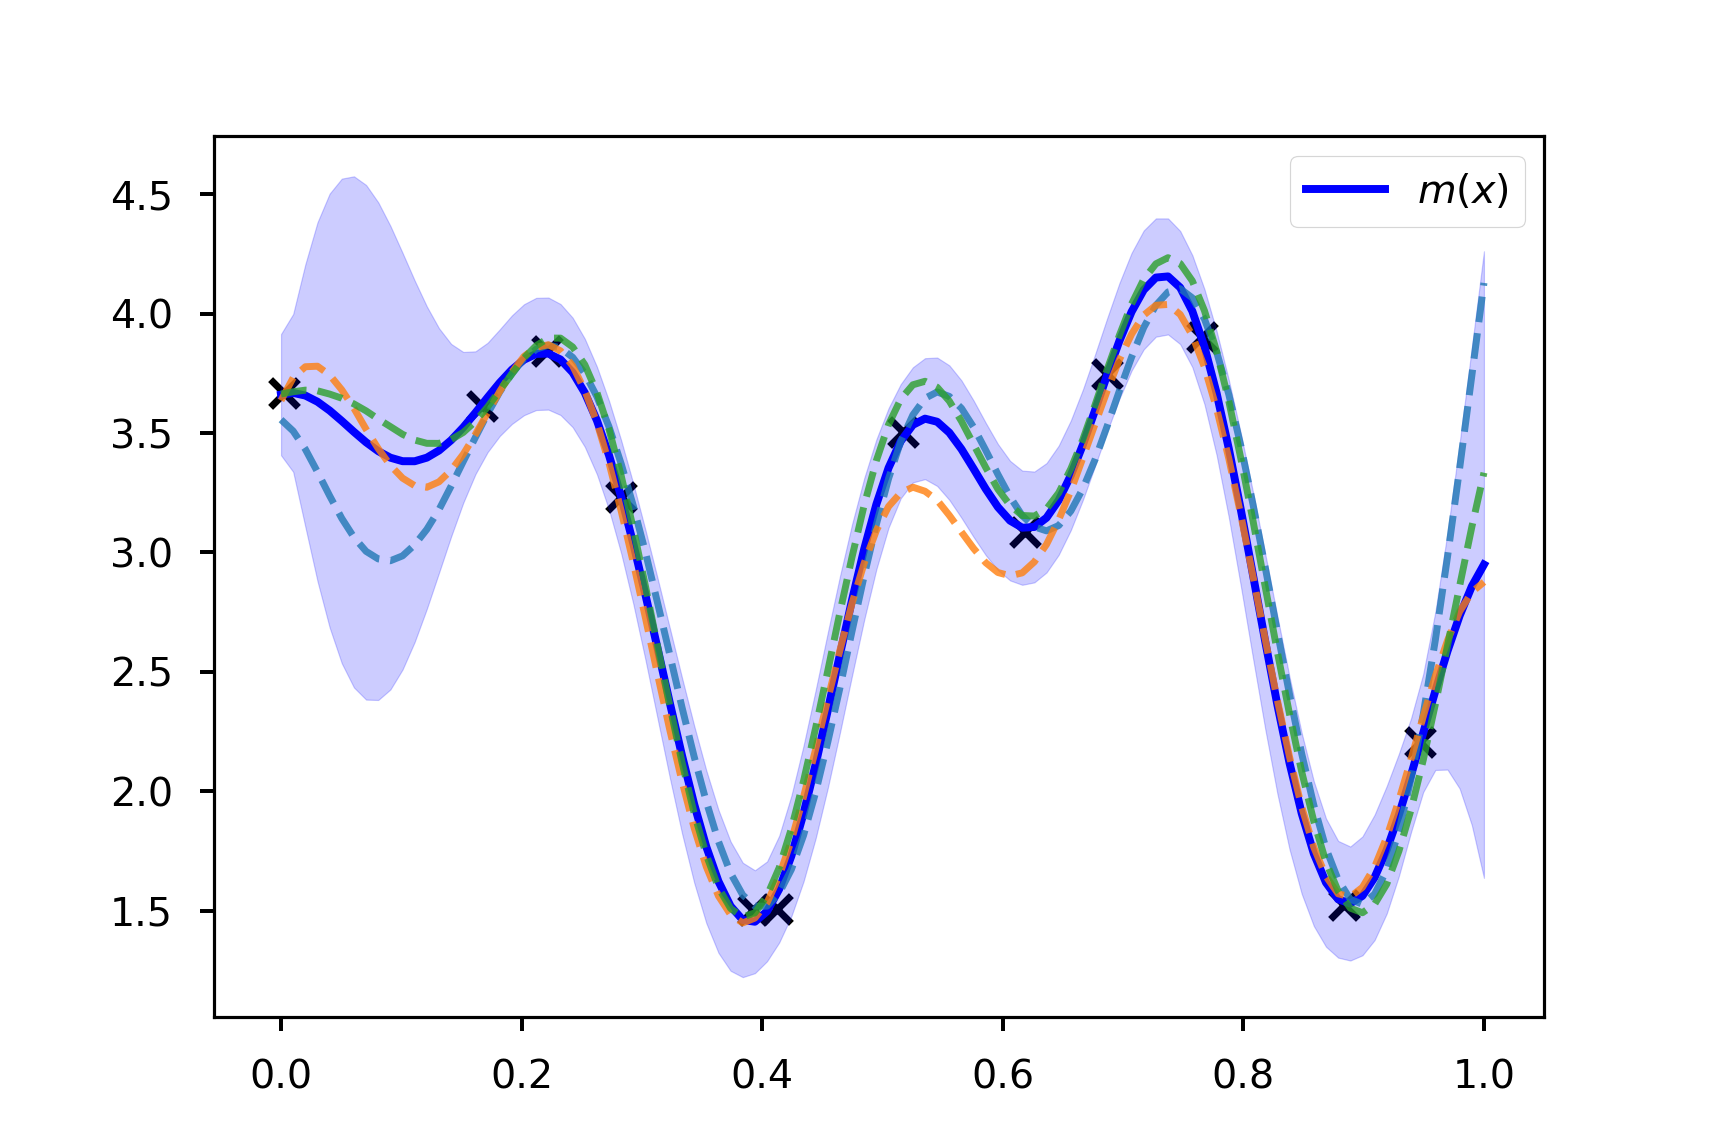

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_posterior_predictive(m, ax=ax)

plt.show()

### Other covariance functions

As we mentioned early, GPFlow implements a number of common covariance functions. Let us experiment with the following subset of them.

In [ ]:
kernels = [
    gpflow.kernels.Matern12(1),
    gpflow.kernels.Matern32(1),
    gpflow.kernels.Matern52(1),
    gpflow.kernels.RBF(1),
]

#### Exercise

As we did for the squared-exponential (RBF) kernel, draw and visualize 3 samples from the GP priors specified by the kernels in the list defined above. 

In [ ]:
### EXERCISE ###
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), 
                         subplot_kw=dict(xticks=[], yticks=[]))
fig.tight_layout()

for ax, k in zip(axes.flat, kernels):
    ### COMPLETE ME ###
    ax.set_title(k.__class__.__name__)
        
plt.show()

In [ ]:
### SOLUTION ###
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), 
                         subplot_kw=dict(xticks=[], yticks=[]))
fig.tight_layout()

for ax, k in zip(axes.flat, kernels):

    ax.set_title(k.__class__.__name__)
    ax.plot(Xq, prior_samples(Xq, k))
            
plt.show()

#### Exercise

For each of the kernels in the list defined above, fit the hyperparameters to the training set and plot the full posterior predictive distribution as we did before for the squared-exponential kernel.

Note that the log marginal likelihood is non-convex so a sensible initialization of the hyperparameters is crucial to avoid getting stuck in a local optimum.

In [ ]:
### EXERCISE ###
fig, axes = plt.subplots(nrows=4, figsize=(6, 10))
fig.tight_layout()
    
for ax, k in zip(axes, kernels):

    m = gpflow.gpr.GPR(X, Y, kern=k)

    ### COMPLETE ME ###
    
    ax.set_title(
        ('{k} ($\ell={{{l[0]:.2f}}},'
         ' \sigma_f={{{sf[0]:.2f}}},'
         ' \sigma_y={{{sy[0]:.2f}}}$)').format(k=k.__class__.__name__,
                                               l=m.kern.lengthscales.value,
                                               sf=m.kern.variance.value,
                                               sy=m.likelihood.variance.value))

    plot_posterior_predictive(m, ax=ax)
            
plt.show()

In [ ]:
### SOLUTION ###
fig, axes = plt.subplots(nrows=4, figsize=(6, 10))
fig.tight_layout()
    
for ax, k in zip(axes, kernels):

    m = gpflow.gpr.GPR(X, Y, kern=k)
    m.likelihood.variance = .01
    m.kern.lengthscales = .1
    m.optimize()
    
    ax.set_title(
        ('{k} ($\ell={{{l[0]:.2f}}},'
         ' \sigma_f={{{sf[0]:.2f}}},'
         ' \sigma_y={{{sy[0]:.2f}}}$)').format(k=k.__class__.__name__,
                                               l=m.kern.lengthscales.value,
                                               sf=m.kern.variance.value,
                                               sy=m.likelihood.variance.value))

    plot_posterior_predictive(m, ax=ax)
            
plt.show()

### Real-world Dataset: Boston Housing Prices

Finally, we apply our GP regression model to the Boston housing prices dataset.

In [ ]:
boston = load_boston()

The dataset has 506 datapoints, with 13 continuous/categorical features and a single target, the median property value. You can view a full description of the dataset and its features:

In [ ]:
Markdown(boston.DESCR)

We can load this dataset into a Pandas DataFrame and view some of its summary statistics.

In [ ]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = pd.Series(boston.target)
boston_df.describe()

For example, we can see how the median property value (`MEDV`) varies with the average number of rooms per dwelling (`RM`).

In [ ]:
fig, ax = plt.subplots()

boston_df.plot.scatter(x='RM', y='MEDV', alpha=.8, ax=ax)

plt.show()

### Automatic Relevance Determination (ARD)

Now let us fit a GP regression model to this dataset. We consider the squared-exponential covariance function as before, except now, we use the *anisotropic* variant of the kernel. That is, we consider a length scale *vector* of 13 positive values. 

These hyperparameter values determine how far you need to move along a particular axis in the input space for the function values to become uncorrelated. By estimating these values we effectively implement automatic relevance determination, as the inverse of the length scale determines the relevance of the dimension. If the length scale is very large, the covariance will practically become independence of that input, and effectively remove it from the inference (GPML $\S$5.1 Rasmussen & Williams, 2006).

In [ ]:
X, y = shuffle(normalize(boston.data), # scaling individual samples to have unit norm
               np.atleast_2d(boston.target).T, # gpflow labels must be 2D 
               random_state=rng)

In GPFlow, we can easily obtain an anisotropic kernel by specifying `ARD=True`.

In [ ]:
k = gpflow.kernels.RBF(13, ARD=True)
m = gpflow.gpr.GPR(X, y, k)
m.likelihood.variance = .1
m.optimize()
m

Let's create a Pandas Series to hold the length scales for ease of visualization and manipulation.

In [ ]:
s = pd.Series(m.kern.lengthscales.value, index=boston.feature_names)
s

We display the bar chart of the length scales corresponding to each dimension.

In [ ]:
fig, ax = plt.subplots()

s.plot.bar(ax=ax)
ax.set_ylabel('$\ell_i$')

plt.show()

Generating the scatter plot with respect to the feature that has the smallest length scale, we find that it is indeed highly correlated with the median property value.

In [ ]:
fig, ax = plt.subplots()

boston_df.plot.scatter(x=s.argmin(), y='MEDV', alpha=.8, ax=ax)

plt.show()

And vice versa for the feature with the largest length scale.

In [ ]:
fig, ax = plt.subplots()

boston_df.plot.scatter(x=s.argmax(), y='MEDV', alpha=.8, ax=ax)

plt.show()